
# 🧠 Robust Multimodal Emotion & Strategy Classifier (ResNet + Audio + Text)

This notebook includes:
- Balanced CSV loading  
- Safe image/audio reading (graceful failure logging)  
- Debug mode with `num_workers=0`  
- Full train/val loop  
- Save and reload trained model


In [8]:

import os, random, json, numpy as np, pandas as pd
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torchaudio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# Config
CSV_PATH = 'MESC_cleaned_no_path.csv'
FRAME_COLS = [f'Frame_{i}' for i in range(1,13)]
TEXT_COL, EMOTION_COL, STRATEGY_COL = 'Utterance','Emotion','Strategy'
SAMPLE_RATE, N_MELS = 16000, 128
BATCH_SIZE, EPOCHS, LR = 128, 10, 2e-4
NUM_WORKERS = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cuda


In [9]:

# Load CSV and encode
df = pd.read_csv(CSV_PATH).dropna(subset=[TEXT_COL,EMOTION_COL,STRATEGY_COL,'Audio']+FRAME_COLS)
le_e, le_s = LabelEncoder().fit(df[EMOTION_COL]), LabelEncoder().fit(df[STRATEGY_COL])
df['emotion_id'], df['strategy_id'] = le_e.transform(df[EMOTION_COL]), le_s.transform(df[STRATEGY_COL])
num_emotions, num_strategies = len(le_e.classes_), len(le_s.classes_)
print(num_emotions,"emotions", num_strategies,"strategies")
train_df, val_df = train_test_split(df,test_size=0.15,random_state=42,stratify=df['emotion_id'])


7 emotions 10 strategies


In [10]:

# Safe loaders
def safe_img(path):
    try:
        path=os.path.normpath(path)
        return Image.open(path).convert('L')
    except Exception as e:
        raise RuntimeError(f"Image failed: {path} -> {e}")
import soundfile as sf
import torchaudio.functional as F

def safe_audio(path):
    try:
        path = os.path.normpath(path)
        # Read using libsndfile backend
        wav, sr = sf.read(path, dtype='float32', always_2d=False)
        wav = torch.tensor(wav, dtype=torch.float32)
        if wav.ndim > 1:  # stereo → mono
            wav = wav.mean(dim=-1)
        wav = wav.unsqueeze(0)  # shape [1, T]
        if sr != SAMPLE_RATE:
            wav = F.resample(wav, sr, SAMPLE_RATE)
        return wav
    except Exception as e:
        raise RuntimeError(f"Audio failed: {path} -> {e}")



In [11]:

img_tf=transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor()])
melspec=torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE,n_mels=N_MELS)
amp2db=torchaudio.transforms.AmplitudeToDB()

class ClipDS(Dataset):
    def __init__(self,df):self.df=df.reset_index(drop=True)
    def __len__(self):return len(self.df)
    def __getitem__(self,i):
        try:
            row=self.df.loc[i]
            fr=[img_tf(safe_img(row[c])) for c in FRAME_COLS]
            wav=safe_audio(row['Audio'])
            mel=amp2db(melspec(wav)).squeeze(0).mean(-1)
            return {'utt':row[TEXT_COL],'frames_12':torch.stack(fr),
                    'audio_feat':mel,'emo':int(row['emotion_id']),'strat':int(row['strategy_id'])}
        except Exception as e:raise RuntimeError(f"Idx {i}: {e}")


C:\Users\Ezaz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchaudio\functional\functional.py:582: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [12]:

def tok(texts,max_len=64):
    arr=[[ord(c)%10000 for c in t][:max_len] for t in texts]
    L=max(len(a) for a in arr)
    x=torch.zeros(len(arr),L).long()
    for i,a in enumerate(arr):x[i,:len(a)]=torch.tensor(a)
    return x,torch.ones_like(x)
def collate(b):
    ids,att=tok([x['utt'] for x in b])
    fr=torch.stack([x['frames_12'] for x in b])
    au=torch.stack([x['audio_feat'] for x in b])
    e=torch.tensor([x['emo'] for x in b]);s=torch.tensor([x['strat'] for x in b])
    return {'input_ids':ids,'att':att,'frames':fr,'audio':au,'emo':e,'strat':s}

train_dl=DataLoader(ClipDS(train_df),batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKERS,collate_fn=collate)
val_dl=DataLoader(ClipDS(val_df),batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKERS,collate_fn=collate)
print("Train:",len(train_dl.dataset))


Train: 10639


In [13]:
from torchvision import models
import torch
import torch.nn as nn

# --- Vision backbone: MobileNetV3-Small for 1-channel input, outputs 576-d ---
def mobilenet_gray():
    m = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)

    # Replace first 3->C conv with 1->C conv and port averaged weights
    first = m.features[0][0]  # Conv2d inside ConvBNActivation
    w = first.weight.mean(1, keepdim=True).clone()  # [C,1,3,3]
    m.features[0][0] = nn.Conv2d(
        in_channels=1,
        out_channels=first.out_channels,
        kernel_size=first.kernel_size,
        stride=first.stride,
        padding=first.padding,
        bias=False,
    )
    m.features[0][0].weight.data = w

    # Make it a feature extractor (global pooled 576-d, classifier removed)
    m.classifier = nn.Identity()
    return m, 576

# --- Text encoder (lighter: same hidden size, fewer heads/layers) ---
class TxtEnc(nn.Module):
    def __init__(self, h=512):
        super().__init__()
        self.emb = nn.Embedding(10000, h)
        e = nn.TransformerEncoderLayer(h, 4, batch_first=True)  # heads=4 (was 8)
        self.enc = nn.TransformerEncoder(e, 1)                  # layers=1 (was 2)

    def forward(self, ids, att):
        x = self.emb(ids)
        return self.enc(x), x[:, 0, :]

# --- Net (process unchanged) ---
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Vision
        self.v, v_dim = mobilenet_gray()        # v_dim = 576
        self.vp = nn.Linear(v_dim, 512)         # project to 512

        # Audio
        self.ap = nn.Linear(N_MELS, 512)

        # Text
        self.t = TxtEnc()

        # Cross-attention (keep same process)
        self.q  = nn.Linear(512, 512)
        self.k  = nn.Linear(512, 512)
        self.vv = nn.Linear(512, 512)
        self.att = nn.MultiheadAttention(512, 8, batch_first=True)

        # Heads
        self.he = nn.Linear(512, num_emotions)
        self.hs = nn.Linear(512, num_strategies)

        # Optional: freeze backbone to reduce training compute
        # for p in self.v.parameters():
        #     p.requires_grad = False

    def forward(self, fr, au, t):
        B = fr.size(0)

        # Vision → encode 12 frames, then average (unchanged)
        v = self.v(fr.view(B * 12, 1, 128, 128))   # [B*12, 576]
        v = v.view(B, 12, -1).mean(1)              # [B, 576]
        v = self.vp(v)                              # [B, 512]

        # Audio → project
        a = self.ap(au)                             # [B, 512]

        # Fuse A+V (unchanged)
        av = (v + a) / 2
        av = av.unsqueeze(1)                        # [B, 1, 512]

        # Text encoding (unchanged interface)
        seq, cls = self.t(t['input_ids'], t['att']) # [B, T, 512]

        # Cross-attention (unchanged)
        q, k, vv = self.q(seq), self.k(av), self.vv(av)
        o, _ = self.att(q, k, vv)                   # [B, T, 512]
        fz = o[:, 0, :]                             # first token

        # Predict
        emo = self.he(fz)
        strat = self.hs(fz)
        return emo, strat



model = Net().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=LR)
ce = nn.CrossEntropyLoss()


In [14]:
from tqdm import tqdm

def run_epoch(model, dl, train=True):
    model.train(train)
    total_emo_loss, total_str_loss = 0.0, 0.0
    correct_emo, correct_str = 0, 0
    total_samples = 0

    phase = "Train" if train else "Val"
    pbar = tqdm(dl, desc=f"{phase} epoch", leave=False)

    for batch in pbar:
        # ---------------- Inputs ----------------
        frames = batch['frames'].to(device)
        audio = batch['audio'].to(device)
        emo_gt = batch['emo'].to(device)
        strat_gt = batch['strat'].to(device)
        text = {'input_ids': batch['input_ids'].to(device),
                'att': batch['att'].to(device)}

        # ---------------- Forward / Backward ----------------
        with torch.set_grad_enabled(train):
            emo_pred, strat_pred = model(frames, audio, text)
            loss_emo = ce(emo_pred, emo_gt)
            loss_str = ce(strat_pred, strat_gt)
            total_loss = loss_emo + loss_str

            if train:
                opt.zero_grad()
                total_loss.backward()
                opt.step()

        # ---------------- Metrics ----------------
        bs = frames.size(0)
        total_samples += bs
        total_emo_loss += loss_emo.item() * bs
        total_str_loss += loss_str.item() * bs
        correct_emo += (emo_pred.argmax(1) == emo_gt).sum().item()
        correct_str += (strat_pred.argmax(1) == strat_gt).sum().item()

        # live display
        pbar.set_postfix({
            "EmoLoss": f"{loss_emo.item():.3f}",
            "StrLoss": f"{loss_str.item():.3f}"
        })

    avg_emo_loss = total_emo_loss / total_samples
    avg_str_loss = total_str_loss / total_samples
    emo_acc = correct_emo / total_samples
    strat_acc = correct_str / total_samples

    return {
        "emo_loss": avg_emo_loss,
        "emo_acc": emo_acc,
        "str_loss": avg_str_loss,
        "str_acc": strat_acc
    }

# ---------------- Training Loop ----------------
history = []
for ep in range(1, 20 + 1):
    print(f"\n🟩 Epoch {ep}/{EPOCHS}")
    train_metrics = run_epoch(model, train_dl, True)
    val_metrics   = run_epoch(model, val_dl, False)

    print(f"📊 Train — "
          f"Emotion Loss: {train_metrics['emo_loss']:.4f}, "
          f"Acc: {train_metrics['emo_acc']*100:.2f}% | "
          f"Strategy Loss: {train_metrics['str_loss']:.4f}, "
          f"Acc: {train_metrics['str_acc']*100:.2f}%")

    print(f"🧪 Val   — "
          f"Emotion Loss: {val_metrics['emo_loss']:.4f}, "
          f"Acc: {val_metrics['emo_acc']*100:.2f}% | "
          f"Strategy Loss: {val_metrics['str_loss']:.4f}, "
          f"Acc: {val_metrics['str_acc']*100:.2f}%")

    history.append((train_metrics, val_metrics))

torch.save(model.state_dict(), "robust_avt_model.pth")
print("\n✅ Model saved as robust_avt_model.pth")



🟩 Epoch 1/10


📊 Train — Emotion Loss: 1.7648, Acc: 34.90% | Strategy Loss: 2.3985, Acc: 20.14%
🧪 Val   — Emotion Loss: 2.0957, Acc: 29.23% | Strategy Loss: 2.2311, Acc: 14.38%

🟩 Epoch 2/10


📊 Train — Emotion Loss: 1.0312, Acc: 58.72% | Strategy Loss: 1.9682, Acc: 28.66%
🧪 Val   — Emotion Loss: 3.5673, Acc: 25.77% | Strategy Loss: 3.1845, Acc: 10.76%

🟩 Epoch 3/10


📊 Train — Emotion Loss: 0.6784, Acc: 72.22% | Strategy Loss: 1.5405, Acc: 43.14%
🧪 Val   — Emotion Loss: 4.2180, Acc: 23.48% | Strategy Loss: 3.8803, Acc: 14.27%

🟩 Epoch 4/10


📊 Train — Emotion Loss: 0.4687, Acc: 82.07% | Strategy Loss: 1.2029, Acc: 55.67%
🧪 Val   — Emotion Loss: 6.9137, Acc: 26.36% | Strategy Loss: 4.6733, Acc: 14.38%

🟩 Epoch 5/10


📊 Train — Emotion Loss: 0.3432, Acc: 87.91% | Strategy Loss: 0.9285, Acc: 66.12%
🧪 Val   — Emotion Loss: 5.4315, Acc: 26.25% | Strategy Loss: 3.7727, Acc: 19.49%

🟩 Epoch 6/10


📊 Train — Emotion Loss: 0.2640, Acc: 90.63% | Strategy Loss: 0.6110, Acc: 77.74%
🧪 Val   — Emotion Loss: 8.0347, Acc: 33.07% | Strategy Loss: 4.1532, Acc: 18.58%

🟩 Epoch 7/10


📊 Train — Emotion Loss: 0.2570, Acc: 91.19% | Strategy Loss: 0.4881, Acc: 82.23%
🧪 Val   — Emotion Loss: 7.0896, Acc: 30.83% | Strategy Loss: 4.3342, Acc: 27.58%

🟩 Epoch 8/10


📊 Train — Emotion Loss: 0.1530, Acc: 94.76% | Strategy Loss: 0.3268, Acc: 88.91%
🧪 Val   — Emotion Loss: 3.2445, Acc: 47.28% | Strategy Loss: 3.5429, Acc: 33.28%

🟩 Epoch 9/10


📊 Train — Emotion Loss: 0.1533, Acc: 94.75% | Strategy Loss: 0.2616, Acc: 91.13%
🧪 Val   — Emotion Loss: 2.4040, Acc: 52.61% | Strategy Loss: 3.9770, Acc: 38.66%

🟩 Epoch 10/10


📊 Train — Emotion Loss: 0.1134, Acc: 96.48% | Strategy Loss: 0.2599, Acc: 91.54%
🧪 Val   — Emotion Loss: 1.5242, Acc: 68.05% | Strategy Loss: 2.2559, Acc: 55.75%

🟩 Epoch 11/10


📊 Train — Emotion Loss: 0.0990, Acc: 96.86% | Strategy Loss: 0.1542, Acc: 95.43%
🧪 Val   — Emotion Loss: 1.4935, Acc: 74.17% | Strategy Loss: 2.1076, Acc: 58.36%

🟩 Epoch 12/10


📊 Train — Emotion Loss: 0.0841, Acc: 97.22% | Strategy Loss: 0.2169, Acc: 93.12%
🧪 Val   — Emotion Loss: 0.2942, Acc: 91.69% | Strategy Loss: 0.4287, Acc: 86.63%

🟩 Epoch 13/10


📊 Train — Emotion Loss: 0.0690, Acc: 97.79% | Strategy Loss: 0.1558, Acc: 95.54%
🧪 Val   — Emotion Loss: 0.1256, Acc: 95.69% | Strategy Loss: 0.2800, Acc: 91.59%

🟩 Epoch 14/10


📊 Train — Emotion Loss: 0.0375, Acc: 98.85% | Strategy Loss: 0.1037, Acc: 97.24%
🧪 Val   — Emotion Loss: 0.1412, Acc: 95.26% | Strategy Loss: 0.2121, Acc: 94.89%

🟩 Epoch 15/10


📊 Train — Emotion Loss: 0.0348, Acc: 98.87% | Strategy Loss: 0.0719, Acc: 98.27%
🧪 Val   — Emotion Loss: 0.0564, Acc: 99.15% | Strategy Loss: 0.0911, Acc: 97.71%

🟩 Epoch 16/10


📊 Train — Emotion Loss: 0.1055, Acc: 97.02% | Strategy Loss: 0.0974, Acc: 97.24%
🧪 Val   — Emotion Loss: 0.1492, Acc: 94.78% | Strategy Loss: 0.2582, Acc: 92.65%

🟩 Epoch 17/10


📊 Train — Emotion Loss: 0.0777, Acc: 97.43% | Strategy Loss: 0.1130, Acc: 96.86%
🧪 Val   — Emotion Loss: 0.1812, Acc: 95.90% | Strategy Loss: 0.3075, Acc: 91.32%

🟩 Epoch 18/10


📊 Train — Emotion Loss: 0.0228, Acc: 99.36% | Strategy Loss: 0.1218, Acc: 96.36%
🧪 Val   — Emotion Loss: 0.1332, Acc: 94.99% | Strategy Loss: 0.1357, Acc: 97.18%

🟩 Epoch 19/10


📊 Train — Emotion Loss: 0.0089, Acc: 99.83% | Strategy Loss: 0.0508, Acc: 98.86%
🧪 Val   — Emotion Loss: 0.0559, Acc: 99.57% | Strategy Loss: 0.1126, Acc: 97.18%

🟩 Epoch 20/10


📊 Train — Emotion Loss: 0.0165, Acc: 99.56% | Strategy Loss: 0.0548, Acc: 98.53%
🧪 Val   — Emotion Loss: 0.0564, Acc: 99.20% | Strategy Loss: 0.3068, Acc: 92.33%

✅ Model saved as robust_avt_model.pth


In [21]:
from PIL import Image
import torch

def predict_sample(model, frame_paths, audio_path, utterance, le_emotion, le_strategy):
    """
    frame_paths: list of 12 grayscale 128x128 image paths
    audio_path: path to WAV file
    utterance: text (string)
    le_emotion, le_strategy: trained label encoders
    """

    # --- Preprocess frames ---
    frames = [img_tf(safe_img(p)) for p in frame_paths]
    frames = torch.stack(frames).unsqueeze(0).to(device)  # [1,12,1,128,128]

    # --- Preprocess audio ---
    wav = safe_audio(audio_path)
    mel = amp2db(melspec(wav)).squeeze(0).mean(-1)
    mel = mel.unsqueeze(0).to(device)  # [1, N_MELS]

    # --- Text tokens ---
    ids, att = tok([utterance])
    text = {'input_ids': ids.to(device), 'att': att.to(device)}

    # --- Forward pass ---
    with torch.no_grad():
        emo_pred, strat_pred = model(frames, mel, text)
        emo_id = emo_pred.argmax(1).item()
        strat_id = strat_pred.argmax(1).item()

    # --- Decode labels ---
    emotion = le_emotion.inverse_transform([emo_id])[0]
    strategy = le_strategy.inverse_transform([strat_id])[0]

    print(f"🧩 Predicted Emotion:  {emotion}")
    print(f"🗣️  Predicted Strategy: {strategy}")

    return emotion, strategy


In [22]:
import matplotlib.pyplot as plt
from IPython.display import Audio, display

def show_prediction_sample(model, df, le_emotion, le_strategy):
    """
    Randomly picks one row from df, visualizes 12 frames, plays audio,
    shows utterance text, and prints predicted + true labels.
    """

    row = df.sample(1).iloc[0]
    frame_paths = [row[f] for f in FRAME_COLS]
    audio_path  = row['Audio']
    utterance   = row['Utterance']

    print("="*90)
    print(f"🎬 Utterance: {utterance}")
    print(f"🎧 Audio: {audio_path}")
    print("="*90)

    # Display frames
    fig, axes = plt.subplots(3, 4, figsize=(12, 8))
    for i, (ax, path) in enumerate(zip(axes.flatten(), frame_paths)):
        try:
            img = Image.open(path).convert("L")
            ax.imshow(img, cmap='gray')
            ax.set_title(f"Frame {i+1}", fontsize=10)
            ax.axis("off")
        except Exception as e:
            ax.text(0.5, 0.5, "Missing", ha='center', va='center')
            ax.axis("off")
    plt.tight_layout()
    plt.show()

    # Play audio
    print("🔊 Playing audio:")
    display(Audio(audio_path, autoplay=False))

    # Run prediction
    pred_emotion, pred_strategy = predict_sample(
        model,
        frame_paths=frame_paths,
        audio_path=audio_path,
        utterance=utterance,
        le_emotion=le_emotion,
        le_strategy=le_strategy
    )

    true_emotion  = row[EMOTION_COL]
    true_strategy = row[STRATEGY_COL]
    print("\n================= RESULT SUMMARY =================")
    print(f"🧩 Predicted Emotion:  {pred_emotion}")
    print(f"🗣️  Predicted Strategy: {pred_strategy}")
    print(f"🎯 True Emotion:        {true_emotion}")
    print(f"🎯 True Strategy:       {true_strategy}")
    print("===================================================")

    return row


🎬 Utterance: That you'd be sorry you ever encouraged me to cry here.
🎧 Audio: audio\Dialogue_ID-0_Season-1_Episode-1_00-00-56.651_00-00-59.719.wav


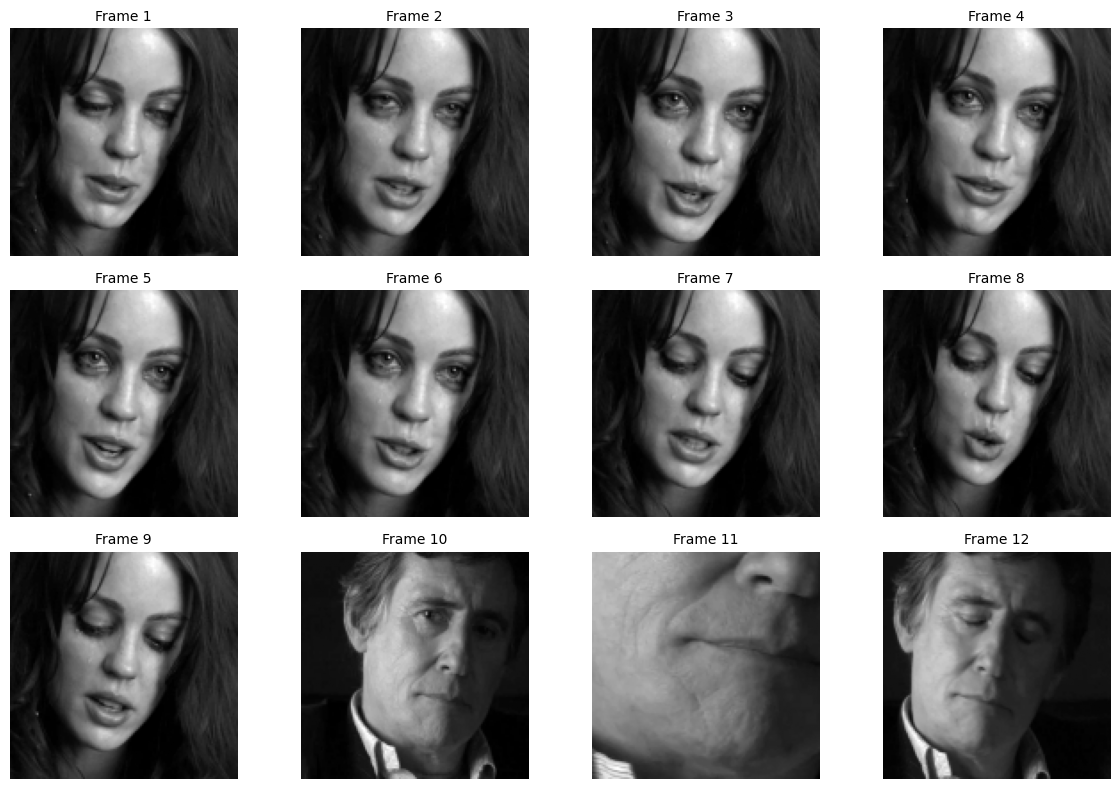

🔊 Playing audio:


🧩 Predicted Emotion:  sadness
🗣️  Predicted Strategy: Communication Skills

================= RESULT SUMMARY =================
🧩 Predicted Emotion:  sadness
🗣️  Predicted Strategy: Communication Skills
🎯 True Emotion:        sadness
🎯 True Strategy:       Communication Skills


Dialogue_ID                                                     0
split_group                                                     1
Season                                                          1
Episode                                                         1
StartTime                                            00:00:56,651
EndTime                                              00:00:59,719
Speaker                                                    Client
Utterance       That you'd be sorry you ever encouraged me to ...
Emotion                                                   sadness
Strategy                                     Communication Skills
Utterance_ID                                                    2
Frame_1         frames\Dialogue_ID-0_Season-1_Episode-1_f01_t0...
Frame_2         frames\Dialogue_ID-0_Season-1_Episode-1_f02_t0...
Frame_3         frames\Dialogue_ID-0_Season-1_Episode-1_f03_t0...
Frame_4         frames\Dialogue_ID-0_Season-1_Episode-1_f04_t0...
Frame_5   

In [24]:

# Load trained model and encoders first (if not already)
model_loaded = Net().to(device)
model_loaded.load_state_dict(torch.load("robust_avt_model.pth", map_location=device))
model_loaded.eval()

# Now predict on a random CSV row
show_prediction_sample(model_loaded, df, le_e, le_s)

